In [20]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx #https://refnx.readthedocs.io/en/latest/installation.html
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
import time
import mpld3 #you may need to pip install mpld3 to get this working - it allows zoom action on inline plots

## Some functions

In [21]:
print(
    f"refnx: {refnx.version.version}\n"
    f"scipy: {scipy.version.version}\n"
    f"numpy: {np.version.version}\n"
)

def save_fig(fig, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr+ ".png"
    fig.savefig(path_out)
    return str(path_out)

def save_text(string, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr + ".txt"
    text_file = open(path_out, "w")
    text_file.write(string)
    text_file.close()
    return str(path_out)

def loadRefData(path,x_start, x_end):
    data = np.loadtxt(path) #load text
    x = data[x_start:x_end,0].T
    y = data[x_start:x_end,1].T/max(data[:,1])
    #conv t-th to q using 0.72769 A wavelength
    x_new = refnx.util.q(x/2, 0.72769) 
    compiled = (x_new,y)
    #returns the ReflectDataset object
    print (f"Model will fit:\nd_min: {min(x_new)} A\n"
       f"d_max: {max(x_new)} A\n")

    return ReflectDataset(compiled)

def simplePlot(x,y,s1,s2):
    plt.loglog(x, y)
    plt.xlabel(s1)
    plt.ylabel(s2)

def plotOut(x,y,s1,s2):
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set(xlabel=s1, ylabel=s2)
    plt.show()
    return fig, ax

refnx: 0.1.49.dev0+a0799c5
scipy: 1.11.4
numpy: 1.26.4



In [22]:
pth = r'/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/XRay/XRR/'

flist = ['lv1_XRR_1_scan1.txt',
 'lv2_XRR_1_scan1.txt',
 'lv3_XRR_1_scan1.txt',
 'lv4_XRR_1_scan1.txt',
 'lv5_XRR_1_scan1.txt',
 'lv6_XRR_1_redo_scan1.txt',
 'lv6_XRR_1_scan1.txt',
 'lv7_XRR_1_scan1.txt',
 'su01_XRR_1_remeas_scan1.txt',
 'su01_XRR_3_scan1.txt',
 'su02_XRR_1_scan1.txt',
 'su03_XRR_1_scan1.txt',
 'su04_XRR_1_scan1.txt',
 'su05_XRR_1_scan1.txt',
 'su06_XRR_1_scan1.txt',
 'su07_XRR_1_scan1.txt',
 'su08_XRR_1_scan1.txt']

## Load and clip data

Model will fit:
d_min: 0.04144265290341968 A
d_max: 0.7939050676792112 A



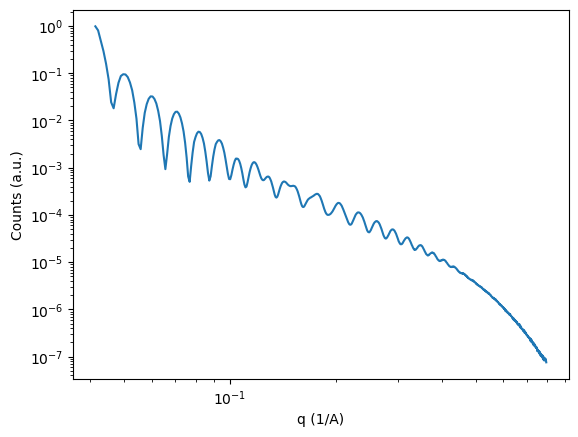

In [23]:
#set the path to your file here. my files have no headers.

#truncate dataset in terms of x datapoints
x_start = 50
x_end = 1050

#load and plot data
data = loadRefData(pth+flist[1], x_start, x_end) #this function loads to the data and converts the x-data from 2-theta to q
simplePlot(data.x, data.y, 'q (1/A)', 'Counts (a.u.)') #plot data

## Generate a Dictionary of Material SLDs

In [24]:
#Define dictionary of materials and corresponding SLDs. You may want to add Nb, for example
SLD_val_dict = {
       'Al2O3': 33.385,
       'Al' : 22.191,
       'Ta' : 112.931,
       'air': 0,
       'native': 28}

#RefNX has SLD objects. I am going to make a dictionary of SLD objects named by the SLD_val_dict labels.
SLD_dict = dict()
for material in SLD_val_dict:
   SLD_dict[material] = SLD(SLD_val_dict[material], name = material)

print ("SLD_val_dict: ", SLD_val_dict, " 1e-6 A^-2")

SLD_val_dict:  {'Al2O3': 33.385, 'Al': 22.191, 'Ta': 112.931, 'air': 0, 'native': 28}  1e-6 A^-2


Model will fit:
d_min: 0.04144265290341968 A
d_max: 0.6079458816751626 A



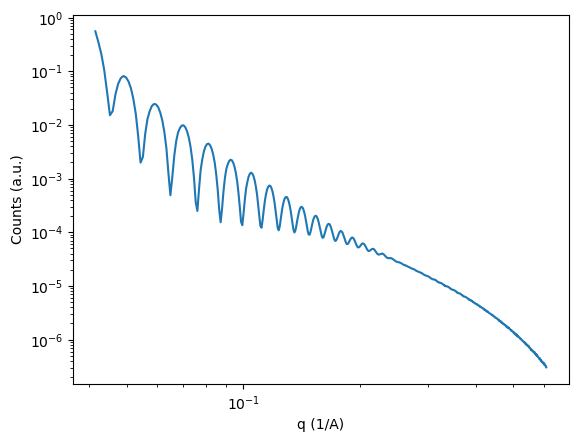

In [25]:
#set the path to your file here. my files have no headers.

#truncate dataset in terms of x datapoints
x_start = 50
x_end = 800

#load and plot data
data = loadRefData(pth+flist[0], x_start, x_end) #this function loads to the data and converts the x-data from 2-theta to q
simplePlot(data.x, data.y, 'q (1/A)', 'Counts (a.u.)') #plot data


1.7723936225732817: : 120it [00:03, 35.99it/s]


________________________________________________________________________________
Objective - 5235335248
Dataset = <None>, 750 points
datapoints = 750
chi2 = 3.5340909644568193
Weighted = False
Transform = Transform('logY')
________________________________________________________________________________
________________________________________________________________________________
<Parameter:    'scale'    , value=0.901685 +/- 0.0218, bounds=[0.9, 1.05]>
<Parameter:     'bkg'     , value=1e-09 +/- 1.81e-06, bounds=[1e-09, 5e-07]>
<Parameter:'dq - resolution', value=0.05  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=-0.000732532 +/- 7.79e-05, bounds=[-0.05, 0.05]>
________________________________________________________________________________
________________________________________________________________________________
<Parameter: 'air - thick' , value=inf  (fixed) , bounds=[-inf, inf]>
_____________________________________________________________________________

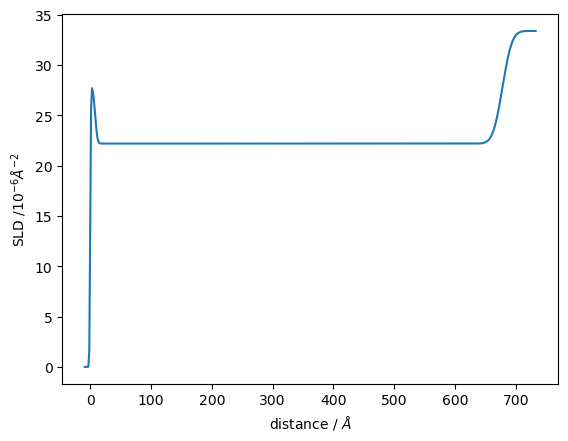

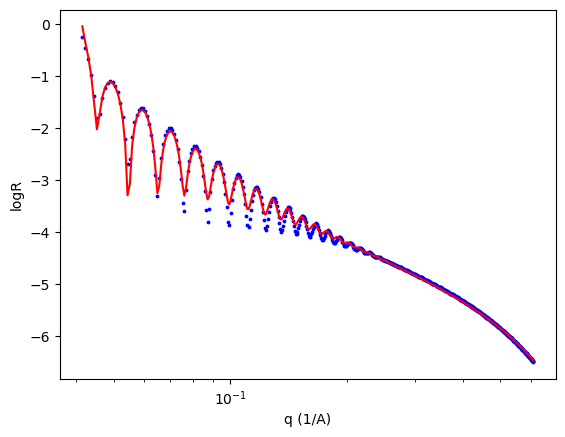

In [26]:

#Define slab parameters. Each row here is a new "slab", which is defined by an SLD, thickness, and roughness.
air = SLD_dict['air'](np.inf,0) #returns a slab with SLD = 0 (for air), infinite thickness, zero roughness.
top_oxide = SLD_dict['native'](8, 1)
top_al = SLD_dict['Al'](670,3)
substrate = SLD_dict['Al2O3'](np.inf,12.4)

#Define structure
structure =  air | top_oxide | top_al | substrate  
plt.plot(*structure.sld_profile())
plt.ylabel("SLD /$10^{-6} \\AA^{-2}$")
plt.xlabel("distance / $\\AA$");

model = ReflectModel(structure, bkg=3e-8, dq=0.05, scale = 1)

model.bkg.setp(bounds = (1e-9, 5e-7), vary = True)
model.scale.setp(bounds = (0.9, 1.05), vary = True)
model.q_offset.setp(bounds = (-.05, 0.05), vary = True)

top_oxide.thick.setp(bounds = (3,12), vary = True)
top_oxide.rough.setp(bounds = (0,20), vary = True)
top_oxide.sld.real.setp(bounds = (20,34), vary = True)

top_al.thick.setp(bounds = (400,900), vary = True)
top_al.sld.real.setp(bounds = (20,24), vary = True)
top_al.rough.setp(bounds = (0,10), vary = True)
    
#JJ_botbuffer.thick.setp(bounds = (0,20), vary = True)
#JJ_botbuffer.sld.real.setp(bounds = (10,30), vary = True)

JJ_buffer.thick.setp(bounds = (0,20), vary = True)
JJ_buffer.sld.real.setp(bounds = (10,30), vary = True)

JJ.thick.setp(bounds = (0,20), vary = True)
JJ.sld.real.setp(bounds = (10,30), vary = True)

bottom_al.thick.setp(bounds = (270,290), vary = True)
substrate.rough.setp(bounds = (5,20))

#Creates the objective
objective = Objective(model, data, transform=Transform("logY"))
#Does the curve fitting
fitter = CurveFitter(objective)
fitter.fit("differential_evolution");
print(objective)

fig1, ax1 = objective.plot();
plt.xlabel("q (1/A)")
plt.ylabel("logR")
plt.xscale('log')


## Define Model and Fitting Parameters

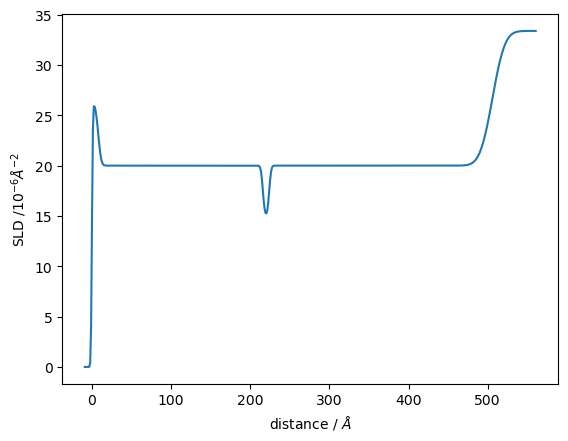

In [27]:
#Define slab parameters. Each row here is a new "slab", which is defined by an SLD, thickness, and roughness.
air = SLD_dict['air'](np.inf,0) #returns a slab with SLD = 0 (for air), infinite thickness, zero roughness.
top_oxide = SLD_dict['native'](8, 1)
top_al = SLD_dict['Al'](208,3)
JJ = SLD(15, name = 'JJ')(4, 2) #in this case I am just specifying an SLD rather than using a dictionary value.
JJ_buffer = SLD(15, name = 'JJ_buffer')(4, 2)
bottom_al = SLD_dict['Al'](282,2)
substrate = SLD_dict['Al2O3'](np.inf,12.4)

#Define structure
structure =  air | top_oxide | top_al |  JJ  | JJ_buffer | bottom_al | substrate  
plt.plot(*structure.sld_profile())
plt.ylabel("SLD /$10^{-6} \\AA^{-2}$")
plt.xlabel("distance / $\\AA$");

model = ReflectModel(structure, bkg=3e-8, dq=0.05, scale = 1)

model.bkg.setp(bounds = (1e-9, 5e-7), vary = True)
model.scale.setp(bounds = (0.9, 1.05), vary = True)
model.q_offset.setp(bounds = (-.05, 0.05), vary = True)

top_oxide.thick.setp(bounds = (3,12), vary = True)
top_oxide.rough.setp(bounds = (0,20), vary = True)
top_oxide.sld.real.setp(bounds = (20,34), vary = True)

top_al.thick.setp(bounds = (200,230), vary = True)
top_al.sld.real.setp(bounds = (20,24), vary = True)
top_al.rough.setp(bounds = (0,10), vary = True)
    
#JJ_botbuffer.thick.setp(bounds = (0,20), vary = True)
#JJ_botbuffer.sld.real.setp(bounds = (10,30), vary = True)

JJ_buffer.thick.setp(bounds = (0,20), vary = True)
JJ_buffer.sld.real.setp(bounds = (10,30), vary = True)

JJ.thick.setp(bounds = (0,20), vary = True)
JJ.sld.real.setp(bounds = (10,30), vary = True)

bottom_al.thick.setp(bounds = (270,290), vary = True)
substrate.rough.setp(bounds = (5,20))

## Fit the Model

In [28]:
#Creates the objective
objective = Objective(model, data, transform=Transform("logY"))

#Does the curve fitting
fitter = CurveFitter(objective)
fitter.fit("differential_evolution");


1.7732434133828583: : 192it [00:09, 19.51it/s]


### Plot Fit

________________________________________________________________________________
Objective - 6233211792
Dataset = <None>, 750 points
datapoints = 750
chi2 = 3.5375542378627007
Weighted = False
Transform = Transform('logY')
________________________________________________________________________________
________________________________________________________________________________
<Parameter:    'scale'    , value=0.900538 +/- 0.0216, bounds=[0.9, 1.05]>
<Parameter:     'bkg'     , value=1e-09 +/- 1.29e-06, bounds=[1e-09, 5e-07]>
<Parameter:'dq - resolution', value=0.05  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=-0.000755739 +/- 7.68e-05, bounds=[-0.05, 0.05]>
________________________________________________________________________________
________________________________________________________________________________
<Parameter: 'air - thick' , value=inf  (fixed) , bounds=[-inf, inf]>
_____________________________________________________________________________

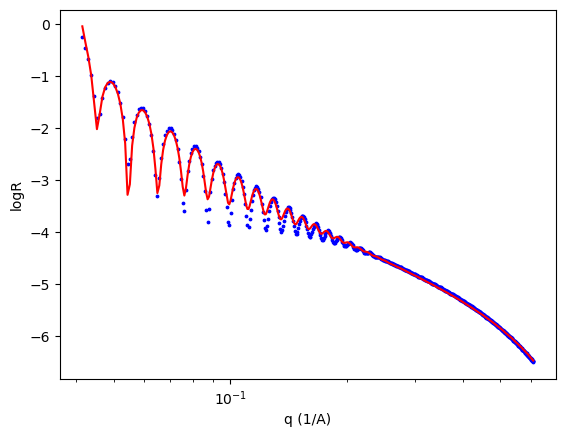

In [29]:
fig1, ax1 = objective.plot();
plt.xlabel("q (1/A)")
plt.ylabel("logR")
plt.xscale('log')

save_name = "lv2_fit" #enter name to save file with (also adds timestamp)



if True: #toggle True to print the full fit, false to not print.
    print(objective)

### Plot SLD Profile from Fit

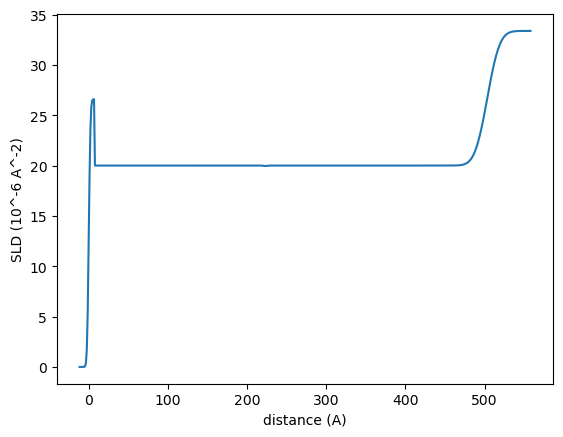

In [31]:
save_name = "lv2_fit" #enter name to save file with (also adds timestamp)

fig, ax = plotOut(structure.sld_profile()[0], structure.sld_profile()[1], "distance (A)", "SLD (10^-6 A^-2)")


## Optimize fit using Markov Chain Monte Carlo model (unclear how useful; typically skip)

/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/Python/refnx/refnx/analysis/curvefitter.py:392: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  init_walkers = rng.multivariate_normal(
100%|██████████| 1000/1000 [00:32<00:00, 30.69it/s]


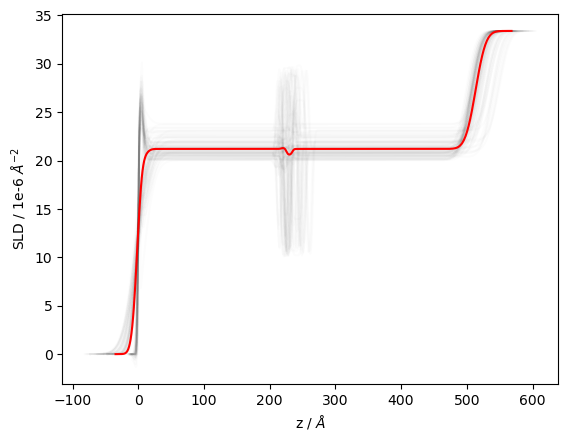

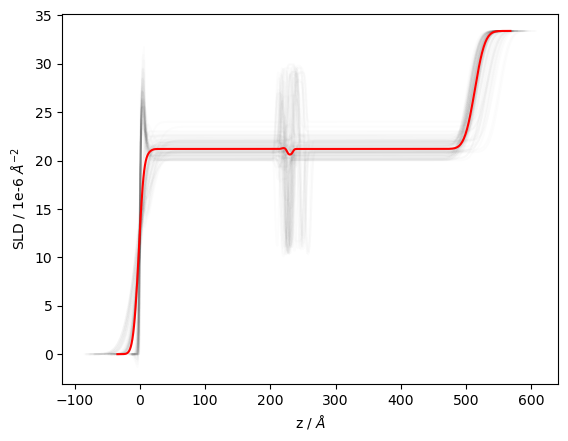

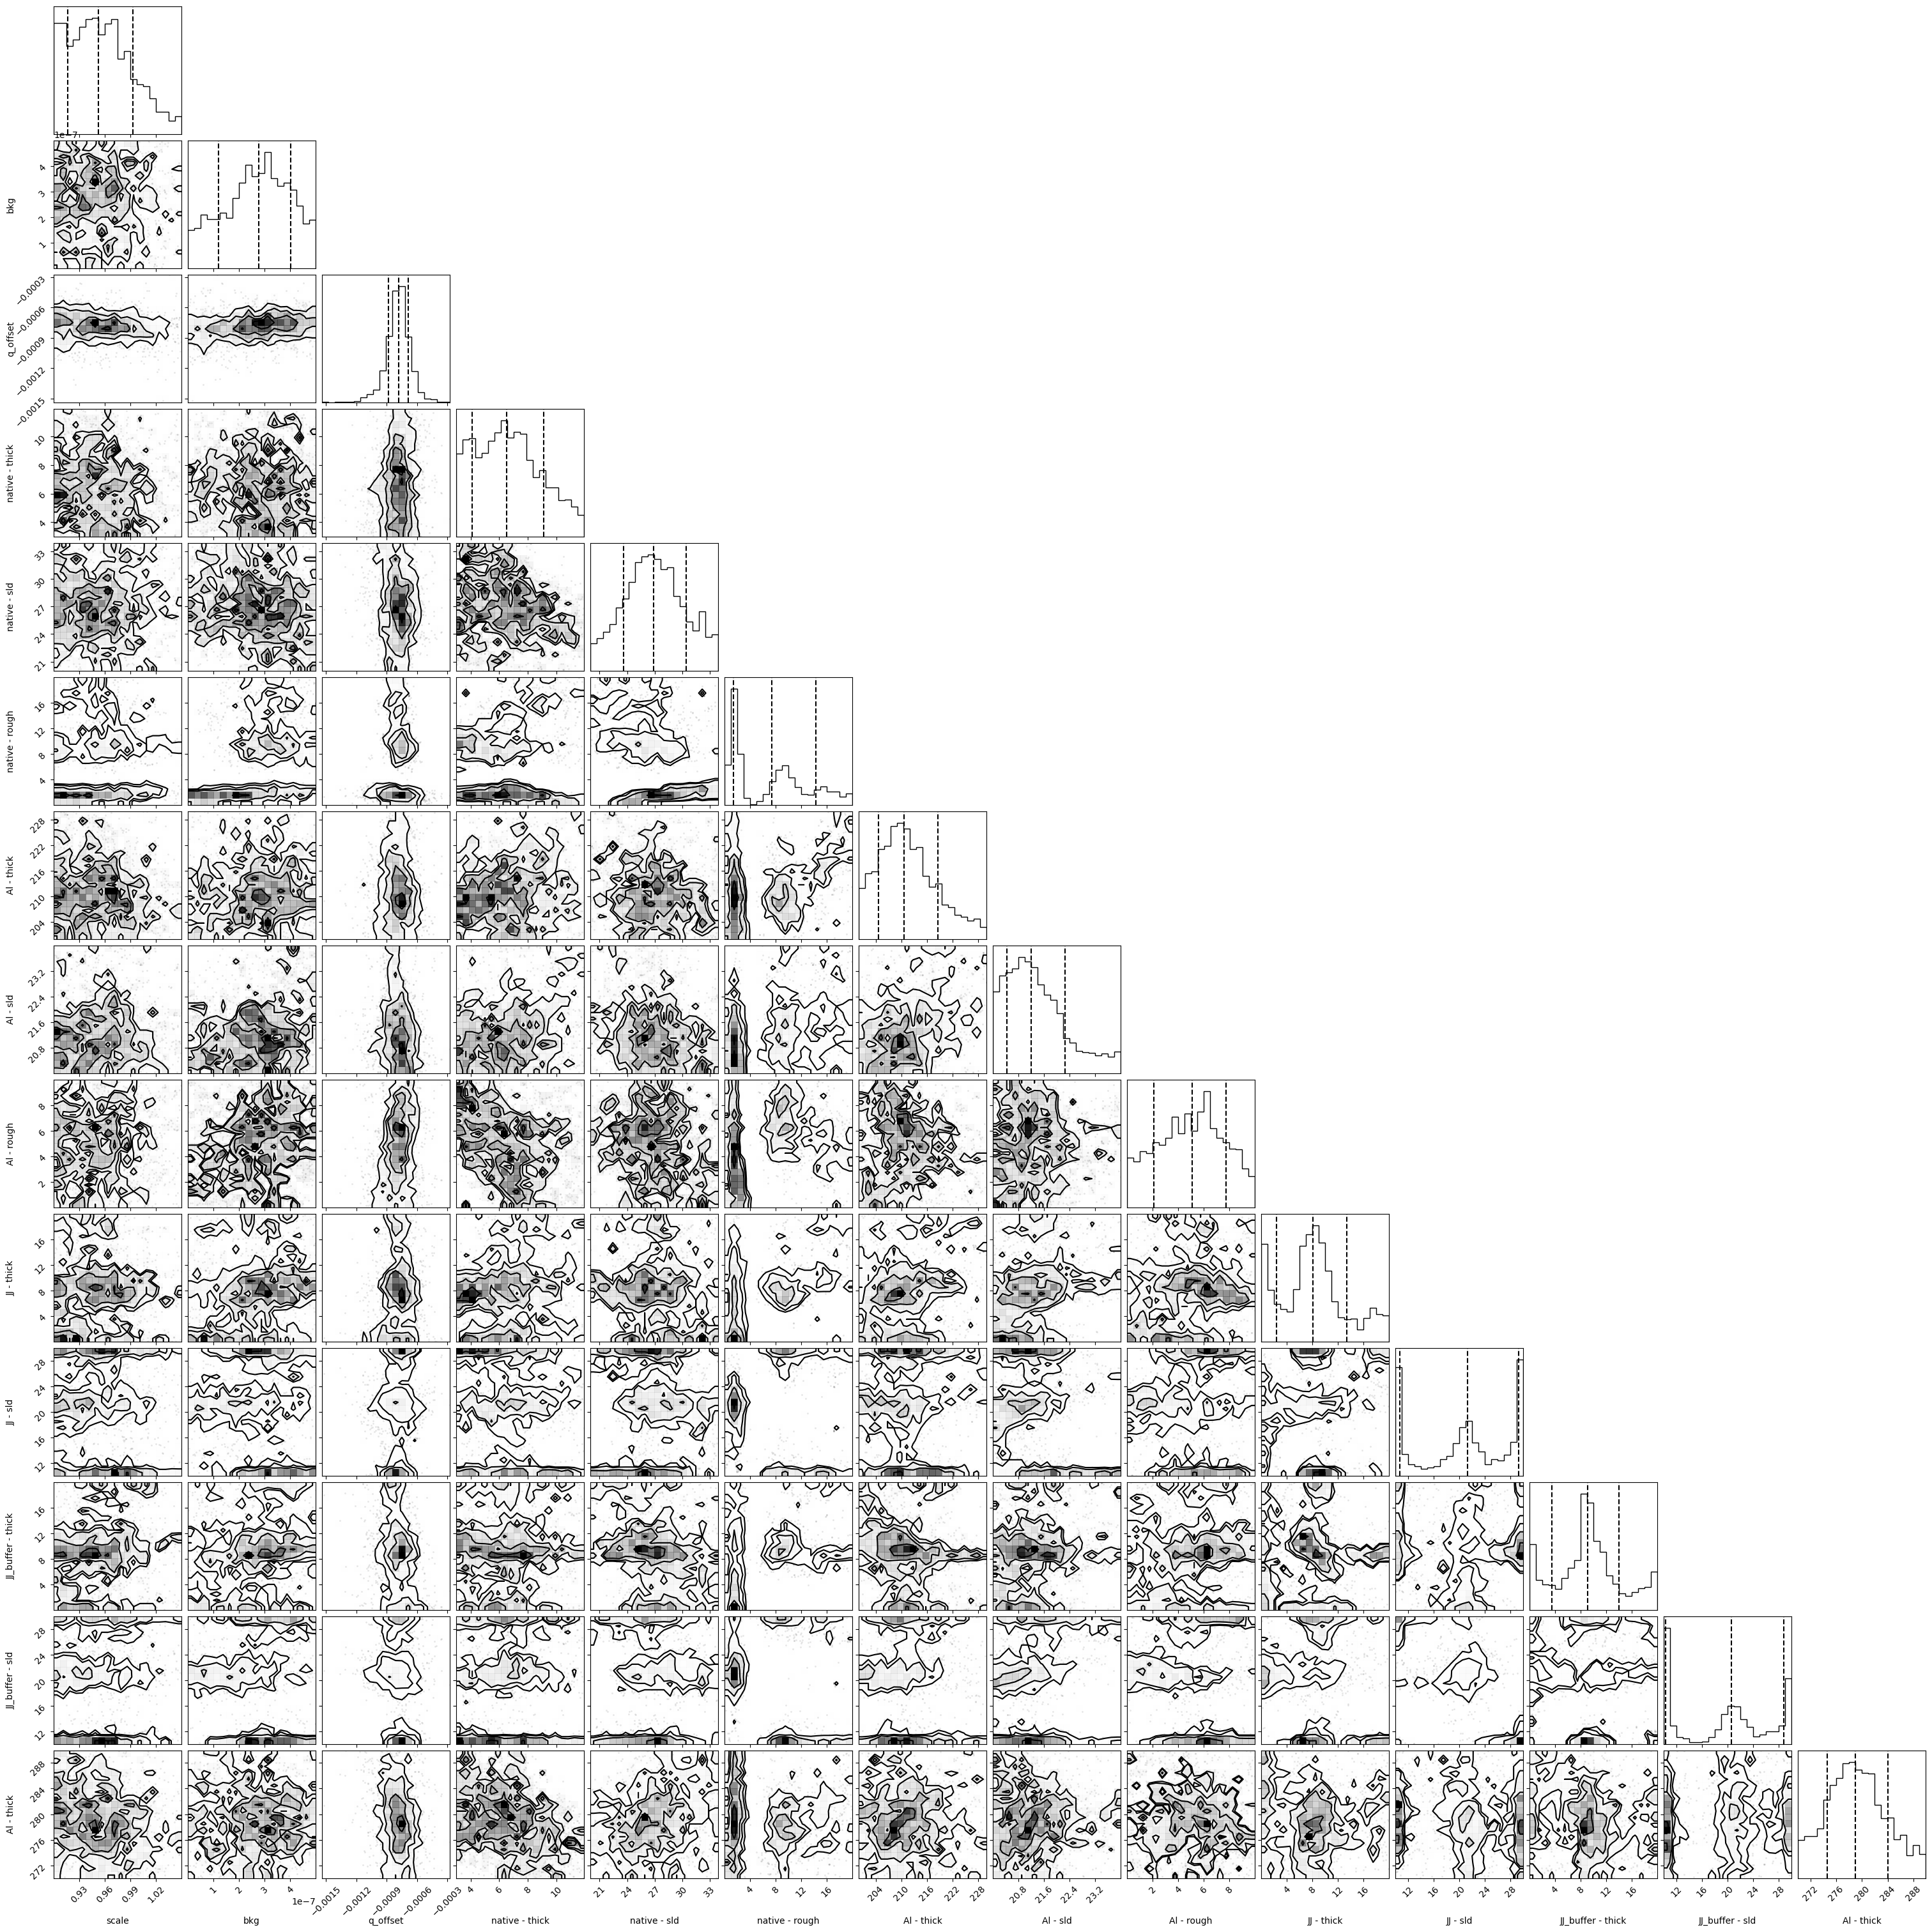

In [32]:
fitter.sample(20, pool=1)
fitter.reset()
res = fitter.sample(10, nthin=100, pool=1)
structure.plot(samples = 100)
fig,ax = structure.plot(samples = 100)
corner_plot = objective.corner();

## Plot the fit residual

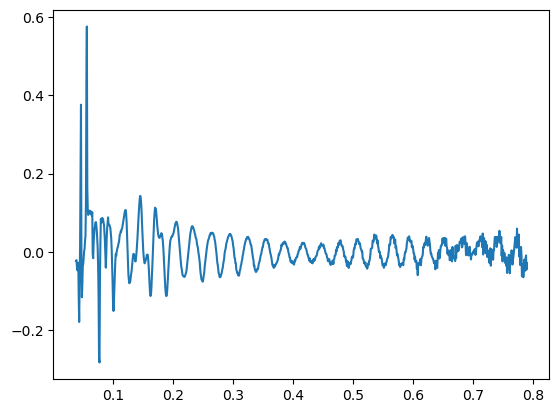

In [ ]:
plt.plot(data.x, objective.residuals())

## Calculate power spectrum of residual to identify missing layers

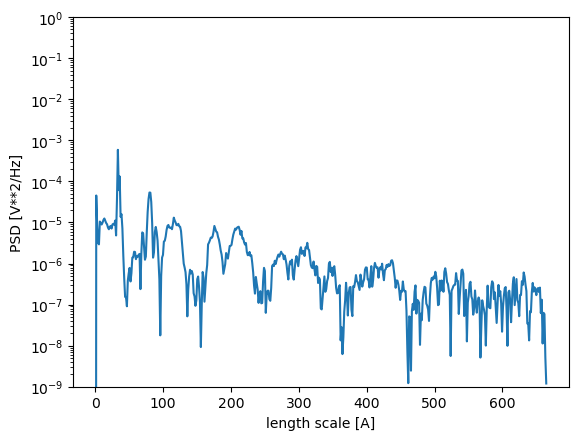

In [21]:

from scipy import signal

mpld3.enable_notebook()

x = objective.residuals()
fs = 1/((max(data.x) - min(data.x)) / len(data.x))
f, Pxx_den = signal.periodogram(x, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-9, 1e0])
plt.xlabel('length scale [A]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

mpld3.disable_notebook()